In [154]:
import chaospy as cp
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use("seaborn-whitegrid")
from scipy.interpolate import interp1d
from scipy.stats import percentileofscore as inverse_percentile
from scipy.special import erf, erfinv
from Utils.RK4 import RK4
from itertools import product 

In [164]:
# Determine the number of standard deviations covering a given probability
alpha = 99 # desired percentage of the total distribution we want to cover
p = 100 - (100-alpha)/2
p = p/100

ndev = np.sqrt(2)*erfinv(2*p-1)
print("+/-{:.3f} std devs cover {}% of a normal distribution".format(ndev, alpha))

+/-2.576 std devs cover 99% of a normal distribution


In [184]:
P = np.eye(2)
P[0,1] = 0.5
P[1,0] = 0.5
print(P)
n = cp.MvNormal([0,0], P)
N = cp.Normal(0, 1)

rho = 0.5 # correlation between x and y 
x0 = np.array([-1,0])

# Nx = cp.Normal(rho*x0[0], 1)
dfdx = N.pdf(x0[0])*(rho*x0[0] + np.sqrt(1-rho**2)*N).cdf(x0[1])
dfdy = N.pdf(x0[1])*(rho*x0[1] + np.sqrt(1-rho**2)*N).cdf(x0[0])
print(dfdx, dfdy)
# c0 = n.cdf(x0)
# print(c0)

[[1.  0.5]
 [0.5 1. ]]
0.17377092959556736 0.04951134587885054


In [3]:
# Examine the statistical properties of a saturation nonlinearity

U = cp.Uniform(-1, 1)
N = cp.Normal(0, 1)

S = N.sample(10000, 'L')

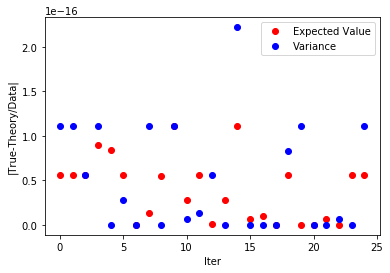

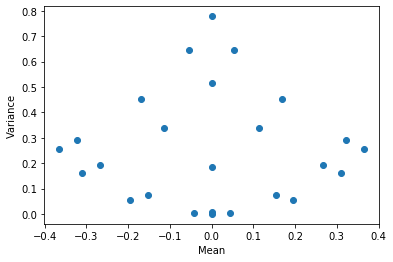

In [4]:
# The expected value is a function of the probability of exceeding the upper and lower bounds of the saturation function
def EVSat(X, L, U):
    PL = inverse_percentile(X, L)/100
    P = inverse_percentile(X, U)/100 - PL
    PU = 1 - P - PL
#     print(PL, P, PU)
    between = np.logical_and(X>=L, X<=U)
    E = np.mean(X[between])
    return PL*L + PU*U + P*E
    
def VarSat(X, L, U):
    PL = inverse_percentile(X, L)/100
    P = inverse_percentile(X, U)/100 - PL
    PU = 1 - P - PL
    between = np.logical_and(X>=L, X<=U)
    V = np.mean(X[between]**2) # not actually the variance
    E = EVSat(X, L, U)

    return PL*L**2 + PU*U**2 + P*V - E**2
    
data = []
for lb,ub in product([-1.5, -1, -0.5, -0.1, -0.01],[0.01, 0.1, 0.5, 1, 1.5]):
#     print(lb, ub)
    y = np.clip(S, lb, ub)
    E = np.mean(y)
    V = np.var(y)
    
    data.append([E, EVSat(S, lb, ub), V, VarSat(S, lb, ub)]) # True, and estimated 
    
E = np.array(data).T
plt.plot(np.abs(E[0]-E[1]), 'ro', label="Expected Value")
plt.plot(np.abs(E[2]-E[3]), 'bo', label="Variance")

plt.xlabel("Iter")
plt.ylabel("|True-Theory/Data|")
plt.legend()

plt.figure()
plt.plot(E[0], E[2], "o")
plt.xlabel("Mean")
plt.ylabel("Variance")
plt.show()

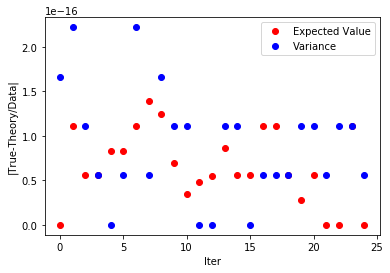

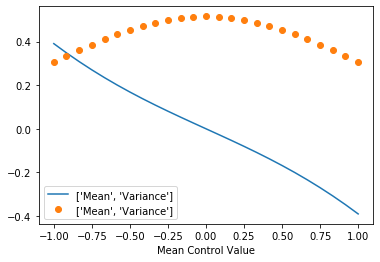

In [5]:
# In the previous section, the actual width of the saturation interval was changing. Here, the interval is fixed, but the mean is changing, which alters the distance to the bounds
data = []
lb = -1
ub = 1
means = np.linspace(-1, 1, 25)
for m in means:
    lb = -1 - m
    ub = 1 -m
    y = np.clip(S, lb, ub)
    E = np.mean(y)
    V = np.var(y)
    
    data.append([E, EVSat(S, lb, ub), V, VarSat(S, lb, ub)]) # True, and estimated 
    
E = np.array(data).T
plt.plot(np.abs(E[0]-E[1]), 'ro', label="Expected Value")
plt.plot(np.abs(E[2]-E[3]), 'bo', label="Variance")

plt.xlabel("Iter")
plt.ylabel("|True-Theory/Data|")
plt.legend()

plt.figure()
plt.plot(means, E[0], means, E[2], "o", label=["Mean", "Variance"])
plt.xlabel("Mean Control Value")
# plt.ylabel("Variance")
plt.legend()
plt.show()

In [6]:
# Examine how the state distribution varies with nominal/saturation 
# The true nonlinear system has control bounds [-1,1]
# Generate an arbitrary nominal control profile u(t)
# Then the bounds are UB-u(t) and LB-u(t)

def dyn(x, t, u0, lb, ub):
    k = 1
    u = np.clip(-k*x, lb-u0(t), ub-u0(t))
    a = 0.25
    return a*x + u 

ub = 1
lb = -1
tf = 15
# x0 = cp.Normal(0, 1).sample(1000, 'L')
x0 = cp.Uniform(-3, 3).sample(1000, 'L')

In [7]:
u = lambda t: np.sin(t/2)*0
t = np.linspace(0, tf, 100)
x = RK4(dyn, x0, t, args=(u, lb, ub))

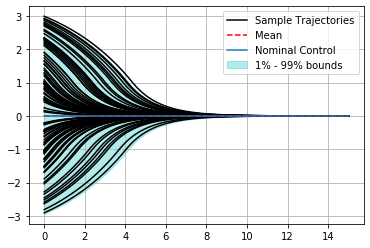

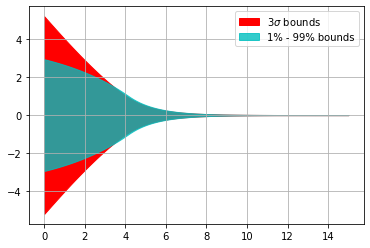

In [8]:
m = np.mean(x, axis=1)
s = np.std(x, axis=1)
plt.plot(t, x.T[0], 'k', label="Sample Trajectories")
plt.plot(t, x[:, ::10], 'k')

plt.plot(t, m, 'r--', label="Mean")
# plt.fill_between(t, m+3*s, m-3*s, alpha=0.3, color='c', label=r"$3\sigma$ bounds")
plt.fill_between(t, np.percentile(x, 99, axis=1), np.percentile(x, 1, axis=1), alpha=0.3, color='c', label=r"1% - 99% bounds")
plt.plot(t, u(t), label="Nominal Control")
plt.grid()
plt.legend()

plt.figure()
# plt.plot(t, x.T[0], 'k', label="Sample Trajectories")
# plt.plot(t, x[:, ::10], 'k')

# plt.plot(t, m, 'r--', label="Mean")
plt.fill_between(t, m+3*s, m-3*s, alpha=1, color='r', label=r"$3\sigma$ bounds")
plt.fill_between(t, np.percentile(x, 99, axis=1), np.percentile(x, 1, axis=1), alpha=0.8, color='c', label=r"1% - 99% bounds")
plt.grid()
plt.legend()

plt.show()

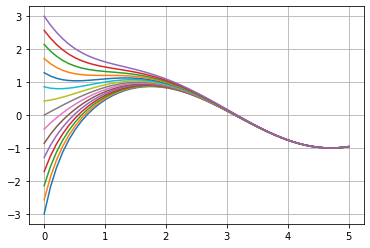

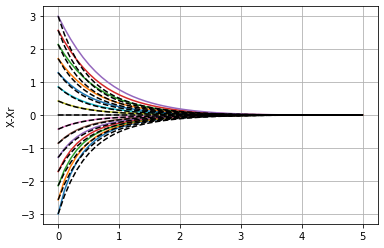

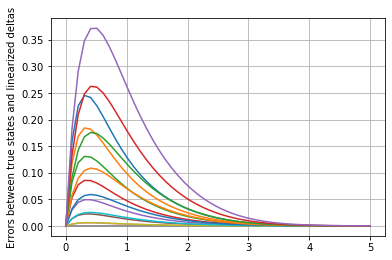

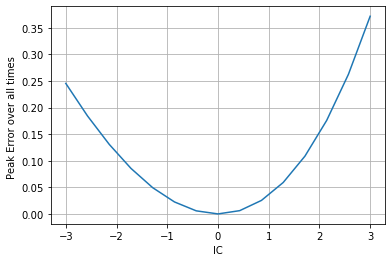

In [18]:
def dyn(x,t,k=-2):
    ur = np.cos(t)-0.25*np.sin(t)**2
    xr = np.sin(t)
    e = x-xr
    u = k*e
    return 0.25*x**2 + ur + u

def dyn_lin(x,t,k=-2):
    return 0.5*np.sin(t)*x + k*x

t = np.linspace(0, 5, 50)
x0 = np.linspace(-3,3, 15)
x = RK4(dyn, x0, t)
xl = RK4(dyn_lin, x0, t)

plt.figure()
plt.plot(t, x)
plt.grid()

plt.figure()
plt.plot(t, x-np.sin(t)[:,None])
plt.plot(t, xl, 'k--')
plt.ylabel("X-Xr")
plt.grid()

plt.figure()
plt.plot(t, x-np.sin(t)[:,None] - xl)
plt.ylabel("Errors between true states and linearized deltas")
plt.grid()

plt.figure()
# plt.plot(t, x-np.sin(t)[:,None])
# plt.plot(t, xl, 'k--')
plt.plot(x0, np.max(np.abs(x-np.sin(t)[:,None] - xl), axis=0))
plt.xlabel("IC")
plt.ylabel("Peak Error over all times ")
plt.grid()

plt.show()

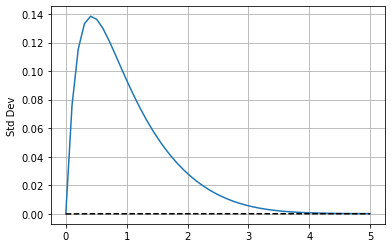

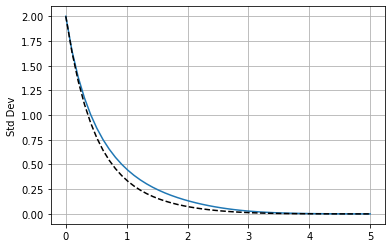

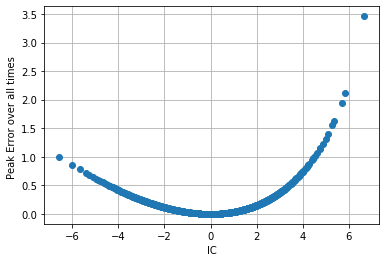

In [20]:
x0 = cp.Normal(0, 2.).sample(1000, 'L')
t = np.linspace(0, 5, 50)
x = RK4(dyn, x0, t)
xl = RK4(dyn_lin, x0, t)


plt.figure()
plt.plot(t, np.mean(x-np.sin(t)[:,None], axis=1))
plt.plot(t, np.mean(xl, axis=1), 'k--')
plt.plot(0, 0, 'k--', label="Linearized")
plt.ylabel("Mean")
plt.grid()
plt.figure()
plt.plot(t, np.std(x-np.sin(t)[:,None], axis=1))
plt.plot(t, np.std(xl, axis=1), 'k--')
plt.plot(0, 0, 'k--', label="Linearized")
plt.ylabel("Std Dev")
plt.grid()

plt.figure()
plt.plot(x0, np.max(np.abs(x-np.sin(t)[:,None] - xl), axis=0), 'o')
plt.xlabel("IC")
plt.ylabel("Peak Error over all times ")
plt.grid()

plt.show()

Gain = 2.1
Gain = 4
Gain = 10


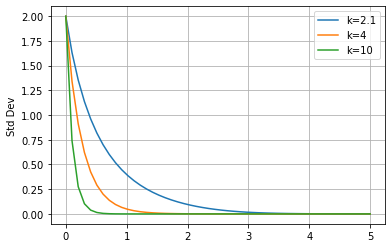

In [25]:
x0 = cp.Normal(0, 2.).sample(1000, 'L')
t = np.linspace(0, 5, 50)

for k in [2.1, 4, 10]:
    print("Gain = {}".format(k))

    x = RK4(dyn, x0, t, args=(-k,))
    xl = RK4(dyn_lin, x0, t, args=(-k,))


    # plt.figure()
    # plt.plot(t, np.mean(x-np.sin(t)[:,None], axis=1))
    # plt.plot(t, np.mean(xl, axis=1), 'k--')
    # plt.plot(0, 0, 'k--', label="Linearized")
    # plt.ylabel("Mean")
    # plt.grid()
    plt.figure(1)
    plt.plot(t, np.std(x-np.sin(t)[:,None], axis=1), label="k={}".format(k))
#     plt.plot(t, np.std(xl, axis=1), 'k--')
#     plt.plot(0, 0, 'k--', label="Linearized")
    plt.ylabel("Std Dev")
    plt.grid()

#     plt.figure()
#     plt.plot(x0, np.max(np.abs(x-np.sin(t)[:,None] - xl), axis=0), 'o')
#     plt.xlabel("IC")
#     plt.ylabel("Peak Error over all times ")
#     plt.grid()
plt.legend()
plt.show()
print("Unsaturated, more gain always means lower variance sooner")

Gain = 0.1
Gain = 1
Gain = 2
Gain = 4
Gain = 100


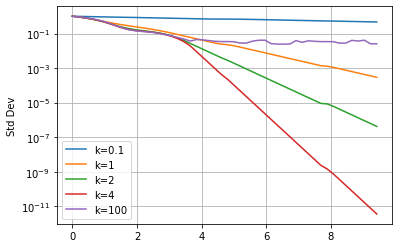

Saturated


In [44]:
def dyn(x,t,k=-2):
    a = 0.005
    xr = np.cos(t)
    dxr = -np.sin(t)
    ur = dxr-a*xr**2

    e = x-xr
    u = k*e
    return a*x*2 + np.clip(ur + u, -1, 1)


x0 = cp.Normal(0, 1.).sample(1000, 'L')
t = np.linspace(0, np.pi*3, 50)

for k in [0.1, 1, 2, 4, 100]:
    print("Gain = {}".format(k))

    x = RK4(dyn, x0, t, args=(-k,))
    xl = RK4(dyn_lin, x0, t, args=(-k,))


    # plt.figure()
    # plt.plot(t, np.mean(x-np.sin(t)[:,None], axis=1))
    # plt.plot(t, np.mean(xl, axis=1), 'k--')
    # plt.plot(0, 0, 'k--', label="Linearized")
    # plt.ylabel("Mean")
    # plt.grid()
    plt.figure(1)
    plt.semilogy(t, np.std(x-np.sin(t)[:,None], axis=1), label="k={}".format(k))
#     plt.plot(t, np.std(xl, axis=1), 'k--')
#     plt.plot(0, 0, 'k--', label="Linearized")
    plt.ylabel("Std Dev")
    plt.grid(1)

#     plt.figure()
#     plt.plot(x0, np.max(np.abs(x-np.sin(t)[:,None] - xl), axis=0), 'o')
#     plt.xlabel("IC")
#     plt.ylabel("Peak Error over all times ")
#     plt.grid()
plt.legend()
plt.show()
print("Saturated")

In [123]:
SN = cp.Normal(0, 1)
m = 1
s = 1.5
N = cp.Normal(m, s)

x = 2

print(SN.pdf((x-m)/s), s*N.pdf(x)) # should be the same
print(SN.cdf((x-m)/s), N.cdf(x)) # should be the same

0.31944800552235225 0.31944800552235225
0.7475074624530771 0.7475074624530771


In [129]:
truncated_var1 =  ((lb-m)*N.pdf(lb)-(ub-m)*N.pdf(ub))/Z, - s**2*((N.pdf(ub)-N.pdf(lb))/Z)**2
alpha = (lb-m)/s
beta = (ub-m)/s
truncated_var =  (alpha*SN.pdf(alpha)-beta*SN.pdf(beta))/Z ,- ((SN.pdf(alpha)-SN.pdf(beta))/Z)**2
print(truncated_var1)
print(truncated_var)

(-0.4465459150509053, -0.005617694656827381)
(-0.4465459150509053, -0.00561769465682738)


Truncated Mean  = 0.8876
Numerical       = 0.8870
Truncated Var   = 1.2326
Numerical       = 1.2329
(0.9658786843958421, 1.734435535823879, -0.1433088008648804, 2.062935637028923)
0.9661471549448316 1.7357115491107393
Saturation clearly reduces the variance as expected


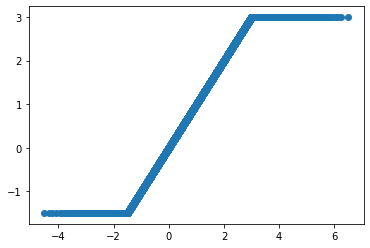

In [152]:
SN = cp.Normal(0, 1) # standard normal for cdf/pdf

lb = -1.5
ub = 3

m = 1
s = 1.5

N = cp.Normal(m, s)
x = N.sample(10000, 'S')
y = np.clip(x, lb, ub)

X = [np.mean(x**i) for i in range(1,4)] # raw moments
Y = [np.mean(y**i) for i in range(1,4)]

mx = X[0], X[1]-X[0]**2, (X[2]-3*X[0]*(X[1]-X[0]**2)-X[0]**3)/(X[1]-X[0]**2)**1.5, np.mean((x-X[0])**4)/(X[1]-X[0]**2)**2 # mean, variance, skewness, kurtosis
mx_true = [m, s**2, 0, 3]

# print(mx_true)
# print(mx)

my = Y[0], Y[1]-Y[0]**2, (Y[2]-3*Y[0]*(Y[1]-Y[0]**2)-Y[0]**3)/(Y[1]-Y[0]**2)**1.5, np.mean((y-Y[0])**4)/(Y[1]-Y[0]**2)**2


truncated_mean_numerical = np.mean(x[np.logical_and(x>lb, x<ub)])
truncated_var_numerical = np.var(x[np.logical_and(x>lb, x<ub)]) 

Z = (N.cdf(ub)-N.cdf(lb))
truncated_mean = m + s**2*(N.pdf(lb)-N.pdf(ub))/Z   # the expected value of the gaussian conditioned to the domain [min, max]. see wiki for truncatead normal
truncated_var = s**2 * (1 + ((lb-m)*N.pdf(lb)-(ub-m)*N.pdf(ub))/Z - s**2*((N.pdf(ub)-N.pdf(lb))/Z)**2)

print("Truncated Mean  = {:.4f}\nNumerical       = {:.4f}".format(truncated_mean, truncated_mean_numerical))
print("Truncated Var   = {:.4f}\nNumerical       = {:.4f}".format(truncated_var, truncated_var_numerical))

mean = N.cdf(lb)*lb + (1-N.cdf(ub))*ub + (N.cdf(ub)-N.cdf(lb))*truncated_mean 
var = N.cdf(lb)*(lb-m)**2 + (1-N.cdf(ub))*(ub-m)**2 + (N.cdf(ub)-N.cdf(lb))*(truncated_var + (truncated_mean-m)**2)
# Note (truncated_var + (truncated_mean-m)**2) = s**2 * (1 + ((lb-m)*N.pdf(lb)-(ub-m)*N.pdf(ub))/Z)
# my_true =  #???
print(my)
print(mean, var)
print("Saturation clearly reduces the variance as expected")
# print(my_true)

plt.scatter(x,y)

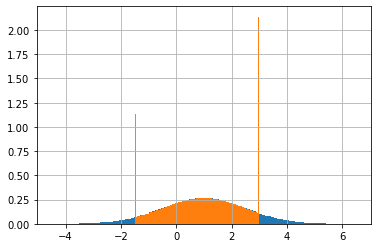

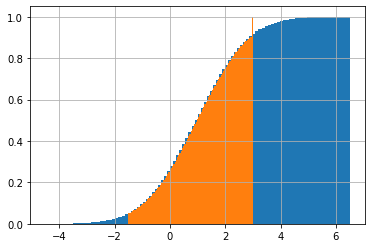

In [107]:
plt.figure()
plt.hist(x, bins=100, density=True)
plt.hist(y, bins=100, density=True)
plt.grid()

plt.figure()

plt.hist(x, bins=100, density=True, cumulative=True)
plt.hist(y, bins=100, density=True, cumulative=True)
plt.grid()

plt.show()

In [497]:
from pyaudi import gdual_double, cos
import Utils.DA as da

m = 0  # mean of the delta, always zero
s = 1.5
N = cp.Normal(m, s)
x = N.sample(10000, 'L')

x0 = 1 # expansion point
z = gdual_double(x0, 'x', 2)
y = 2*z + 3*z**2  # specifically choose a function that can be perfectly represented to be sure our formulas are correct 
print(y)
a,b = y.find_cf([1]), y.find_cf([2])

ya = da.evaluate([y], ['x'], x)  # actual values

dym = b*(s**2) 
ym = y.find_cf([0]) + dym    # analytical mean calc

# yv = a**2*np.mean(x**2) + b**2*np.mean(x**4) - dym**2 # hack with numerical parts - works 
yv = a**2*(s**2) + b**2*(2*s**4) #- dym**2 # analytical variance 
ys = yv**0.5  ## standard deviation analytical

ey3n = np.mean((ya-ym)**3)
# ey3 = -3*a**2*b*(s**4) + 3*a**2*b*(3*s**4) - b**3*s**6 + 3*b**3*s**6 - 3*b**3*(3*s**6) + b**3*(15*s**6)
ey3 = 6*a**2*b*(s**4) + 8*b**3*s**6 # simplified from the above 
skew = ey3/ys**3

ey4n = np.mean((ya-ym)**4)
# ey4 = a**4*(3*s**4) + 6*a**2*b**2*(s**4) - 12*a**2*b**2*(3*s**6) + 6*a**2*b**2*(15*s**6) + b**4*s**8 - 4*b**4*s**8 + 6*b**4*(3*s**8) - 4*b**4*(15*s**8) + b**4*(105*s**8)
ey4 = (3*a**4 + 6*a**2*b**2)*(s**4) + (-12*3 +6*15)*a**2*b**2*s**6 + (1-4+18-60+105)*b**4*s**8  # collected like terms in above exp
kurt = ey4/ys**4
                                        
print('              Analytical        Numerical')
print("Mean:         {:.3f}             {:.3f}".format(ym, np.mean(ya)))
print("Std :         {:.3f}             {:.3f}".format(ys, np.std(ya)))
print("Skew:         {:.3f}              {:.3f}".format(skew, ey3n/ys**3))
print("Kurtosis:     {:.3f}             {:.3f}".format(kurt, ey4n/ys**4))

3*dx**2+5+8*dx
              Analytical        Numerical
Mean:         11.750             11.750
Std :         15.334             15.336
Skew:         2.300              2.304
Kurtosis:     10.103             10.547


In [554]:
# reference: https://en.wikipedia.org/wiki/Quadratic_form_(statistics)
# reference: Probability Moments of Quadratic Forms (in Dropbox - Mathematics)


m = 0  # mean of the delta, always zero
s = 2
P = np.diag([s,s*0.5])**2 # covariance matrix 
N = cp.MvNormal([0,0], P)
dx = N.sample(10000, 'L')
print(dx.shape)
x0 = 1 # expansion point
xda = gdual_double(x0, 'x', 2)
yda = gdual_double(x0, 'y', 2)

z = 2*xda - yda + 6*yda**2 - 3*xda*yda  
za = da.evaluate([z], ['x','y'],  dx.T)
J = da.gradient(z, ['x','y'])
H = 0.5*da.jacobian(da.differentiate(z, ['x','y']), ['x','y'])

mean = z.find_cf([0,0]) + np.trace(H.dot(P))
meann = np.mean(za)
var = J.dot(P).dot(J.T) + 2*np.trace(H.dot(P).dot(H).dot(P))
std = np.sqrt(var)
stdn = np.std(za)

skew = (6*J.dot(P).dot(J.T)*np.trace(H.dot(P)) + 8*np.trace(H.dot(P).dot(H).dot(P).dot(H).dot(P)))/std**3 
skewn = np.mean((za-mean)**3)/stdn**3
print('              Analytical        Numerical')
print("Mean:         {:.3f}             {:.3f}".format(mean, meann))
print("Std :         {:.3f}             {:.3f}".format(std, stdn))
print("Skew:         {:.3f}              {:.3f}".format(skew, skewn))

# plt.scatter(*dx, c=za)
# plt.colorbar()

(2, 10000)
              Analytical        Numerical
Mean:         10.000             10.070
Std :         13.266             13.336
Skew:         2.344              2.513


In [423]:
da.jacobian(da.differentiate(z, ['x','y']), ['x','y'])
# da.differentiate(z, ['x','y'])

array([[ 0., -3.],
       [-3.,  2.]])

## In conclusion, we can analytically compute the first four moments of a second order polynomial analytically from its coefficients if the initial uncertainty is described by Normal distributions.

In [522]:
def standard_transform(covariance):
    values, vectors = np.linalg.eig(covariance)
#     print(values, vectors)
    Vi = np.linalg.inv(vectors)
    T = vectors.T.dot(np.diag(values**-0.5)).dot(Vi)
    Ti = vectors.T.dot(np.diag(values**0.5)).dot(Vi)

    return T,Ti
    
def standardize(data):
    """ Returns the data with zero mean and identity covariance matrix, 
    as well as the transform variables m and T such that
    data ~ m + T*N where N is a standard mvnormal distribution
    """
    m = np.mean(data, axis=1, keepdims=True)
    c = np.cov(data) # need correct axis'
    T,Ti = standard_transform(c)
    d = T.dot(data-m)
    return d, m, Ti
    
# P = np.array([[2, 0.5],[0.5,3]])
# A = standard_transform(0, P)

x = cp.MvNormal([0,0], np.diag([3,2])).sample(100, 'L')
y,_,_ = standardize(x)
print(np.mean(y), np.cov(y))

-1.5543122344752193e-17 [[ 1.00000000e+00 -1.38767969e-16]
 [-1.38767969e-16  1.00000000e+00]]
